In [1]:
import pandas as pd

import _background as bg
import molNet
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader
from molNet.featurizer.atom_featurizer import atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, \
    atom_is_aromatic, atom_is_in_ring, atom_symbol_one_hot_from_set, atom_total_degree_one_hot, atom_chiral_tag_one_hot, atom_total_num_H_one_hot
from molNet.featurizer.featurizer import FeaturizerList
import pytorch_lightning as pl
import torch

In [2]:
dataset = pd.read_csv("data/qm9.csv")
tasks=[
    "mu", "alpha", "homo", "lumo", "gap", "r2", "zpve", "cv", "u0", "u298",
    "h298", "g298","u0_atom","u298_atom","h298_atom","g298_atom"
]

In [3]:
scaled_dataset=dataset.copy()
scalef={}
for t in tasks:
    sf=[scaled_dataset[t].min(),1]
    scaled_dataset[t]= scaled_dataset[t]-sf[0]
    sf[1]=scaled_dataset[t].max()
    scaled_dataset[t]= scaled_dataset[t]/sf[1]
    scalef[t]=sf
scaled_dataset

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.000000,0.036257,0.125115,0.792673,0.803682,...,0.111623,1.000000,1.000000,1.000000,1.000000,0.011399,0.923639,0.923451,0.923449,0.922795
1,gdb_2,N,293.60975,293.541110,191.393970,0.055000,0.016552,0.524931,0.699864,0.527699,...,0.071347,0.976195,0.976194,0.976194,0.976196,0.007665,0.973376,0.973203,0.973129,0.973854
2,gdb_3,O,799.58812,437.903860,282.945450,0.062629,0.000000,0.415418,0.661330,0.563849,...,0.021024,0.946705,0.946704,0.946704,0.946709,0.000000,1.000000,1.000000,1.000000,1.000000
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.000000,0.052388,0.440808,0.612212,0.519665,...,0.042210,0.945364,0.945364,0.945364,0.945366,0.062782,0.928022,0.928179,0.928391,0.925806
4,gdb_5,C#N,0.00000,44.593883,44.593883,0.097904,0.035101,0.208626,0.526730,0.594142,...,0.002519,0.921475,0.921474,0.921474,0.921477,0.006737,0.962956,0.963136,0.963370,0.960594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133880,gdb_133881,C1C2C3C4C5OC14C5N23,3.59483,2.198990,1.904230,0.056289,0.331354,0.621597,0.634464,0.434477,...,0.432008,0.465716,0.465716,0.465716,0.465713,0.430981,0.419338,0.419290,0.419804,0.417158
133881,gdb_133882,C1N2C3C2C2C4OC12C34,3.65648,2.142370,1.904390,0.043903,0.332142,0.579076,0.639891,0.461255,...,0.432353,0.465722,0.465722,0.465722,0.465720,0.431933,0.420426,0.420371,0.420877,0.418335
133882,gdb_133883,C1N2C3C4C5C2C13CN45,3.67118,2.143140,1.895010,0.042224,0.353581,0.628021,0.670285,0.453054,...,0.482598,0.495208,0.495208,0.495208,0.495204,0.438646,0.393011,0.392789,0.393227,0.391738
133883,gdb_133884,C1N2C3C4C5CC13C2C45,3.52845,2.151310,1.865820,0.066233,0.373548,0.661976,0.713976,0.461423,...,0.528197,0.518993,0.518993,0.518993,0.518989,0.458759,0.339760,0.339573,0.340104,0.337034


In [4]:
import matplotlib.pyplot as plt
import numpy as np

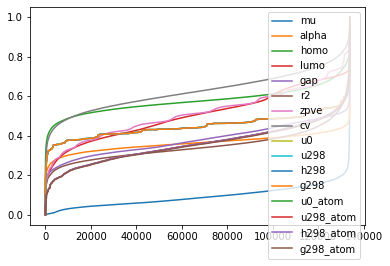

In [5]:
for t in  tasks:
    plt.plot(np.sort(scaled_dataset[t]),label=t)
plt.legend()
plt.show()
plt.close()


In [6]:
#dataset["rd_mol"]=dataset["smiles"].apply(bg.MolFromSmiles)
#c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)

from molNet.featurizer.featurizer import OneHotFeaturizer
def _get_atom_symbol(atom):
    return atom.GetSymbol()
c_mp_atom_symbol_featurizer = OneHotFeaturizer(
    possible_values=['O', 'Si', 'Na', 'H', 'P', 'F', 'S', 'C', 'Cl', 'N', 'B', 'Br','I',None],
    pre_featurize=_get_atom_symbol,
    name="atom_symbol_one_hot",
)

featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_total_degree_one_hot,
    atom_formal_charge,
    atom_partial_charge,
    atom_chiral_tag_one_hot,
    #atom_total_num_H_one_hot,
    atom_hybridization_one_hot,
    atom_is_aromatic,
    atom_is_in_ring,
])

In [7]:
loader_Qm9Model1 = PytorchGeomMolDfLoader(scaled_dataset,
                                         y_columns=tasks,
                                         columns=[],
                                         atom_featurizer=featurizer,
                                         inplace=True,
                                         seed=2,
                                         batch_size=512,
                                         to_graph_input_kwargs=dict(
                                             with_mol_graph=True
                                         ),
                                    #        worker=1,
                                            path="test/qm9.pckl"
                                            
                                         )
#import os
#os.remove("test/storage2.pckl")

In [8]:
%%time
loader_Qm9Model1.setup()
for d in loader_Qm9Model1.test_dataloader():
    print(d)
    break

Batch(batch=[9147], edge_index=[2, 18968], mol_graph=[512], x=[9147, 38], x_graph_features=[512, 0], y=[9147, 0], y_graph_features=[512, 16])
CPU times: user 49.2 s, sys: 4.27 s, total: 53.5 s
Wall time: 53.1 s


In [10]:
model_Qm9Model1 = bg.ChemGCModel(in_size=len(featurizer),
                          out_size=len(tasks),
                              n_chem_layer = 20,
                              chem_layer_feats_out=64,
                              chem_layer_gc_out=32,
                              chem_layer_net_sizes=32,
                              chem_layer_net_count=2,
                              collector_net_depth=6,
                              collector_net_depth_red_fac=2,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum","pool_wsum"],
                              lr=0.0001,
                                lossf=torch.nn.MSELoss(),
                                 dropout=0.15
                             )

model_Qm9Model1 = bg.ChemGCModel(in_size=len(featurizer),out_size=len(tasks),
                         post_pool_norm=True,
    
    n_chem_layer = 10,
    chem_layer_feats_out=64,
    chem_layer_gc_out=32,
    chem_layer_net_sizes=32,
    chem_layer_net_count=2,
    collector_net_depth=6,
    collector_net_depth_red_fac=2,
    poolings=["pool_min","pool_max","pool_mean","pool_nwsum","pool_wsum"],
    lr=0.001,
                                lossf=torch.nn.RMSELoss(),
                                 dropout=0.15
                             )

model_parameters = filter(lambda p: p.requires_grad, model_Qm9Model1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

7934083

In [ ]:
model_Qm9Model1

In [9]:
study=bg.load_study("Qm9Model1")
print(len(study.trials))
#study.best_trialtasks

[I 2021-06-15 16:46:15,617] Using an existing study with name 'Qm9Model1_study' instead of creating a new one.


0


In [ ]:
trial=bg.trialwrapper()

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pool_names=["pool_min","pool_max","pool_mean","pool_sum","pool_wsum","pool_nwsum"]
sudy=bg.optimize_model(model_Qm9Model1.__class__,"Qm9Model1",loader_Qm9Model1,n_trials=1000,
                fixed_params=dict(in_size=len(featurizer),out_size=1,lossf=torch.nn.RMSELoss()),
                suggestion_params=dict(
                    lr=trial.suggest_loguniform("lr",1e-4, 1e-2),
                    n_chem_layer = trial.suggest_int("n_chem_layer",2,12),
                    chem_layer_feats_out=trial.suggest_int("chem_layer_feats_out",12,64),
                    chem_layer_gc_out=trial.suggest_int("chem_layer_gc_out",8,64),
                    chem_layer_net_sizes=trial.suggest_int("chem_layer_net_sizes",0,64),
                    chem_layer_net_count=trial.suggest_int("chem_layer_net_count",1,3),
                    collector_net_depth=trial.suggest_int("collector_net_depth",2,8),
                    collector_net_depth_red_fac=trial.suggest_float("collector_net_depth_red_fac",1,3),
                    dropout=trial.suggest_float("dropout",0,1),
                    poolings=trial.suggest_multiple(
                        values=pool_names,
                        names = ["use_"+pn for pn in pool_names],
                        minimum=1,
                    ),
                ),
                  verbose=True,
                  trainer_params=dict(
                      max_epochs=1000,
                      callbacks=lambda:[EarlyStopping(
                        monitor='val_loss',patience=60,
                            min_delta=0.00,
                        )]
                  )
                 )

In [22]:
pools= []
if study.best_trial.params["use_pool_max"] or True:
    pools.append("pool_max")
if study.best_trial.params["use_pool_min"] or True:
    pools.append("pool_min")
if study.best_trial.params["use_pool_mean"] or True:
    pools.append("pool_mean")
if study.best_trial.params["use_pool_nwsum"] or True:
    pools.append("pool_nwsum")
if study.best_trial.params["use_pool_sum"] or True:
    pools.append("pool_sum")
if study.best_trial.params["use_pool_wsum"] or True:
    pools.append("pool_wsum")

print(pools)
model_Qm9Model1 = model_Qm9Model1.__class__(
    in_size=len(featurizer),
    out_size=len(tasks),
    lossf=torch.nn.RMSELoss(),
    n_chem_layer = study.best_trial.params["n_chem_layer"],
    chem_layer_feats_out=study.best_trial.params["chem_layer_feats_out"],
    chem_layer_gc_out=study.best_trial.params["chem_layer_gc_out"],
    chem_layer_net_sizes=study.best_trial.params["chem_layer_net_sizes"],
    chem_layer_net_count=study.best_trial.params["chem_layer_net_count"],
    collector_net_depth=study.best_trial.params["collector_net_depth"],
    collector_net_depth_red_fac=study.best_trial.params["collector_net_depth_red_fac"],
    poolings=pools,
    lr=study.best_trial.params["lr"],
    dropout=study.best_trial.params["dropout"],
)

ValueError: Record does not exist.

train_loss tensor(0.0562, device='cuda:0') val_loss tensor(0.0535, device='cuda:0') 


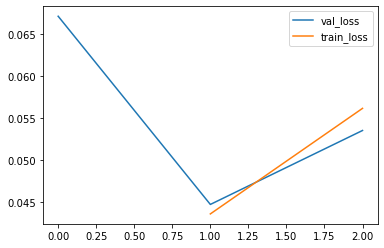

Epoch 2, step 551: val_loss was not in top 1


In [ ]:
model_Qm9Model1,data_Qm9Model1 = bg.default_model_run(
        "Qm9Model1",
        model_Qm9Model1,
        loader_Qm9Model1,
                      force_run=True,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=1000,
                    early_stopping_delta=0.0,
                   detect_lr=False,
                    early_stop_patience=200,
    )

In [ ]:
import numpy as np
#list(model_FGModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_Qm9Model1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [ ]:
true=[]
pred=[]
try:
    loader_Qm9Model1.train_dataloader()
except:
    loader_Qm9Model1.setup()
    
for l in [
        #loader_Qm9Model1.train_dataloader(),
        #  loader_Qm9Model1.val_dataloader(),
          loader_Qm9Model1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_Qm9Model1(d).detach().numpy().tolist())
        true.extend(d.y_graph_features.numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)

In [ ]:
pred.shape

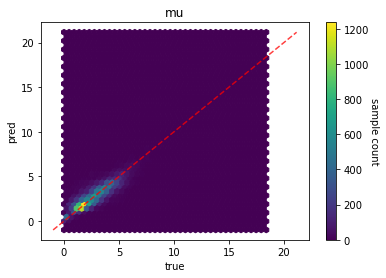

0.7911038762461792 0.5394432740033988


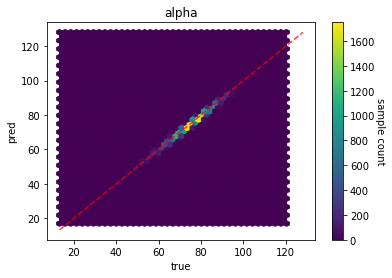

1.2371934570696366 0.8444156342808361


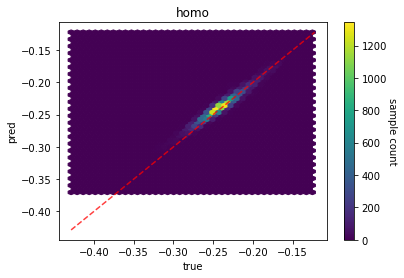

0.007119704861045548 0.005077681134737775


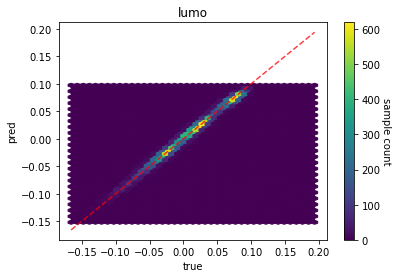

0.006438075710820077 0.004474980660457345


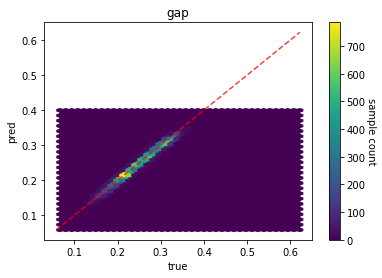

0.009663273976116655 0.0066208887564197655


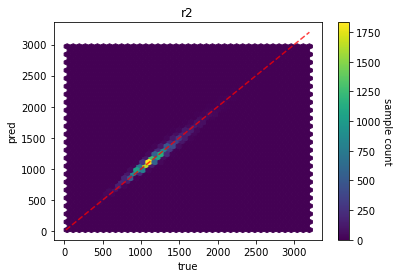

51.406071079408925 34.67826469567024


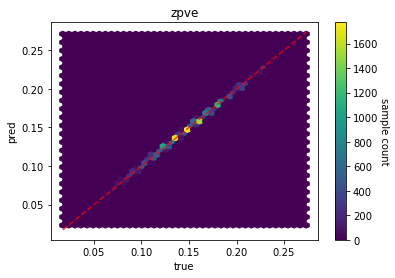

0.0013310635201276154 0.0010269858400250244


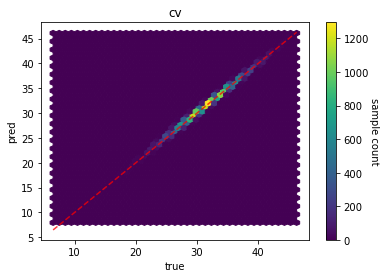

0.3885036135070697 0.25950743369709833


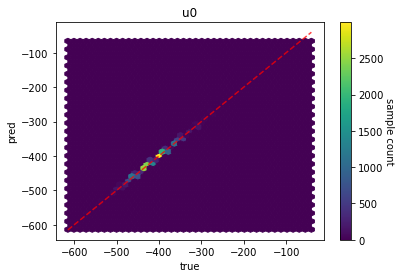

2.019645004151425 1.419358632151742


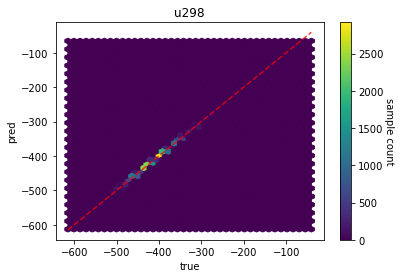

1.9609545979939624 1.3733784033241054


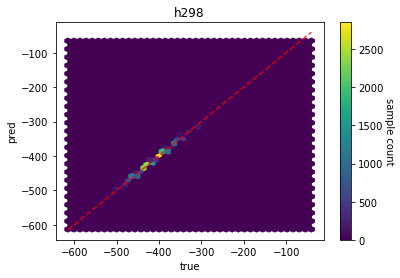

2.02029636871871 1.4175611917501716


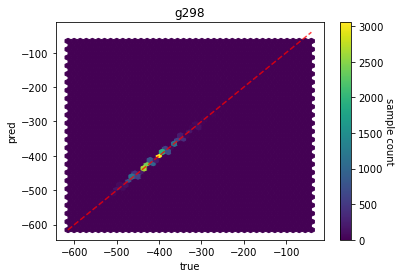

2.0759750551514338 1.4809988109932442


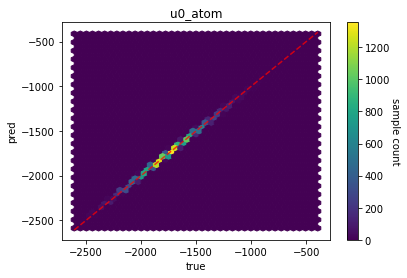

9.611500743087312 7.11104326830248


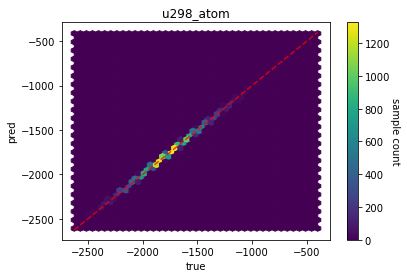

9.591367898839321 7.079063859362151


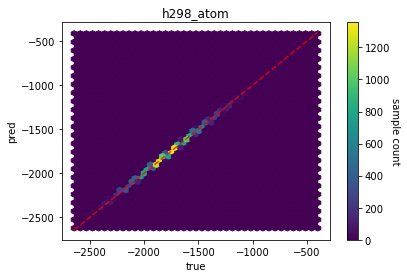

9.603145495413223 7.086470524762775


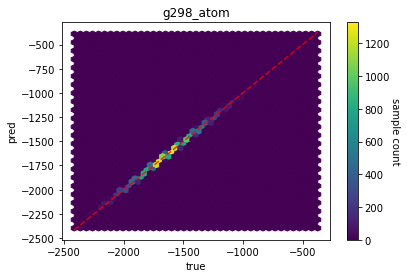

9.381822157424905 6.923467854455302


In [36]:
import matplotlib.pyplot as plt


rp=[]
rt=[]
for i in range(pred.shape[1]):
    task=tasks[i]
    t=true[:,i]*scalef[task][1]+scalef[task][0]
    p=pred[:,i]*scalef[task][1]+scalef[task][0]
    rp.append(p)
    rt.append(t)
    dmin=min(t.min(),p.min())
    dmax=max(t.max(),p.max())
    plt.hexbin(t,p,gridsize=40)
    plt.plot([dmin,dmax],[dmin,dmax],"--r",alpha=0.75)
    #plt.plot(true,pred,"o",alpha=0.3,markeredgecolor="w")
    plt.xlabel("true")
    plt.ylabel("pred")
    plt.title(task)
    clb = plt.colorbar() 
    clb.set_label('sample count', rotation=270,labelpad=10)
    plt.show()
    plt.close()
    print(np.sqrt((np.abs(p-t)**2).mean()),np.abs(p-t).mean())
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [17]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
import datetime
np.sqrt((np.abs(np.concatenate(rp)-np.concatenate(rt))**2).mean()),np.abs(np.concatenate(rp)-np.concatenate(rt)).mean(),datetime.datetime.now()

(13.751867175478218,
 4.389385882446574,
 datetime.datetime(2021, 6, 23, 15, 13, 5, 787883))

In [ ]:
import numpy as np
ysa=np.array(ys)

''

In [ ]:
import optuna
study = optuna.create_study(study_name="aaa",
                            direction="minimize",
                           )